In [13]:
import numpy as np
import torch
import time
import psutil
import sys
sys.path.append("../")
import NewtonMethod
import gaussianKernel
import losses
import display
from importlib import reload

## Dividing training and test set 

In [14]:
# loading file

filepath= "../DATASETS/Susy.pt"
X = torch.load(filepath)

# shuffle file

n = X.size(0)
d = X.size(1)-1
l = np.array(range(n))
np.random.shuffle(l)
X = X[l,:]
del l


# divide in training and test set 

ntr = int(np.ceil(n*0.8))
nts = n - ntr

Xtr = X[:ntr,1:]
Xts = X[ntr:,1:]
Ytr = X[:ntr,0].unsqueeze_(1)
Yts = X[ntr:,0].unsqueeze_(1)
del X

# processing training features : centering and renormalizing

def recenter(W,m,s):
    W-= m.unsqueeze(0).expand_as(W)
    W /= s.unsqueeze(0).expand_as(W)
    
m = Xtr.mean(0)
s = Xtr.std(0)
recenter(Xtr,m,s)
recenter(Xts,m,s)
del m
del s

# putting labels to -1,1

Ytr *= 2
Ytr -= 1
Yts *= 2
Yts -= 1

## Setting general parameters 

In [15]:
# Nystrom points
m = 10000
l = np.array(range(ntr))
np.random.shuffle(l)
l = l[:m]
C = Xtr[l,:]
yC = Ytr[l,:]
# loss
loss = losses.logloss
#UseGPU
useGPU = True
#memory_to_use
memToUse = 0.9*psutil.virtual_memory().available

List of $\sigma$ we want to test for the kernel part

In [16]:
#List of sigma to see
lSigma = [5]


List of regularization parameter $\lambda$ we wish to test

In [19]:
#list of lambda to seee
la_list = [1e-6,1e-8,1e-9,1e-9,1e-9,1e-9,1e-9,1e-10,1e-10,1e-10,1e-10,1e-10,1e-11,1e-11,1e-11,1e-11,1e-11,1e-12,1e-12,1e-12,1e-12,1e-12]
t_list = [3,3,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8]

In [20]:
saveFolder = "SusyData/gridSearch/logloss_third_round"

In [21]:
display = reload(display)
NewtonMethod = reload(NewtonMethod)

In [22]:
cobj = display.cobjTestGrid(Xts,Yts,la_list,lSigma,m,saveFolder = saveFolder)

In [ ]:
for sigma in lSigma:
    kern = gaussianKernel.gaussianKernel(sigma)
    torch.cuda.empty_cache()
    alpha = NewtonMethod.NewtonMethod(loss,Xtr,C,Ytr,yC,kern,la_list,t_list,memToUse = memToUse,cobj = cobj)

cobj.makeTables()

there is 9.492578125 GiB free on the GPU 
number of approximate newton steps performed : 0         in 40.736676931381226 seconds
Performed 1 steps of the conjugate gradient method
Performed 2 steps of the conjugate gradient method
Performed 3 steps of the conjugate gradient method
number of approximate newton steps performed : 1         in 144.98382782936096 seconds
Performed 4 steps of the conjugate gradient method
Performed 5 steps of the conjugate gradient method
Performed 6 steps of the conjugate gradient method
number of approximate newton steps performed : 2         in 249.3805091381073 seconds
Performed 7 steps of the conjugate gradient method
Performed 8 steps of the conjugate gradient method
Performed 9 steps of the conjugate gradient method
Performed 10 steps of the conjugate gradient method
Performed 11 steps of the conjugate gradient method
Performed 12 steps of the conjugate gradient method
Performed 13 steps of the conjugate gradient method
Performed 14 steps of the conju

# Plots

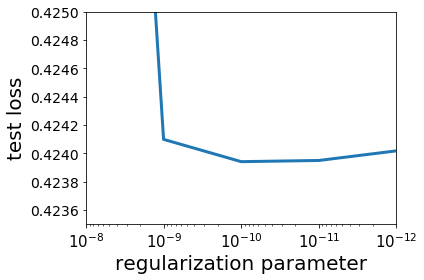

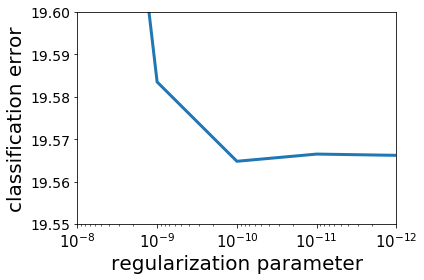

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
m = 10000
sigma = 5
saveFolder = "SusyData/gridSearch/logloss_third_round"
path = saveFolder + "grid search : m = {} ".format(m)
path_loss = path + "test loss table.csv"
path_error = path + "test error table.csv"

figure_path = "SusyData/figures/"

df_loss = pd.read_csv(path_loss)
df_error = pd.read_csv(path_error)
loss_array = np.array(df_loss['sigma = {}'.format(sigma)][1:])
lambda_array = np.array(df_loss['lambda'][1:])
error_array = np.array(df_error['sigma = {}'.format(sigma)][1:])

fig = plt.figure()
plt.semilogx(lambda_array,loss_array,lw = 3)
plt.xlim(1e-8,1e-12)
plt.ylim(0.4235,0.425)
plt.xlabel('regularization parameter',fontsize = 20)
plt.ylabel('test loss',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize =14)
#plt.locator_params(axis='y', nbins=6)
plt.tight_layout()
plt.show()
fig.savefig(figure_path  + 'test_loss_evolution with m = {}.pdf'.format(m) , format='pdf', dpi=1000)
fig = plt.figure()
plt.semilogx(lambda_array,error_array,lw = 3)
plt.xlabel('regularization parameter',fontsize = 20)
plt.ylabel('classification error',fontsize = 20)
plt.xlim(1e-8,1e-12)
plt.ylim(19.55,19.6)
plt.xticks(fontsize = 15)
plt.yticks(fontsize =14)
#plt.locator_params(axis='y', nbins=6)
plt.tight_layout()
fig.savefig(figure_path  + 'class_error_evolution with m={}.pdf'.format(m) , format='pdf', dpi=1000)
plt.show()

